<a href="https://colab.research.google.com/github/spyrosviz/Injury_Prediction_MidLong_Distance_Runners/blob/main/EDA%20Feature%20Importance/EDA_Runners_Injury_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
!pip install bioinfokit
from bioinfokit.visuz import cluster
from sklearn.manifold import MDS
!pip install imbalanced
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ERROR: Could not find a version that satisfies the requirement imbalanced (from versions: none)
ERROR: No matching distribution found for imbalanced


In [ ]:
# Read excel, set variables and target and show basic statistics for each variable
df = pd.read_excel(r'/content/drive/MyDrive/Runners_Injury_MLproject/run_injur_with_acuteloads.xlsx',index_col = [0])
df.drop(['Date','Athlete ID','Total Weekly Distance'],axis=1,inplace=True)
y = df['injury'].values
# Total weekly distance is redundant
X = df.drop(['injury'],axis=1).values

# standardized data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

column_names = df.drop(['injury'],axis=1).columns
print(column_names)

print(df.describe())
print(df['injury'].value_counts())

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

#Detect multicollinearity between variables with variance inflation factor

In [ ]:
'''VIF'''

# detect multicollinearity with variance inflation factor

df_vif = pd.DataFrame()
df_vif["Feature"] = column_names
df_vif["VIF"] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
df_vif_sort = df_vif.sort_values(by=['VIF'],ascending=False)
print(df_vif_sort[:20])

                        Feature        VIF
70                   Acute Load  28.406106
40               nr. sessions.4  12.765160
30               nr. sessions.3  12.755747
20               nr. sessions.2  12.743389
50               nr. sessions.5  12.593339
10               nr. sessions.1  12.587629
0                  nr. sessions  12.520270
60               nr. sessions.6  12.384298
71                     Monotony  12.210280
72                       Strain   9.956638
31                   total km.3   8.047618
41                   total km.4   8.038747
21                   total km.2   8.027816
51                   total km.5   7.945301
11                   total km.1   7.839638
61                   total km.6   7.831137
1                      total km   7.755935
38  perceived trainingSuccess.3   7.687605
48  perceived trainingSuccess.4   7.687487
28  perceived trainingSuccess.2   7.662983


# Detect multicollinearity based on R squared. We set the threshold to 0.6 value.

  Created wheel for collinearity: filename=collinearity-0.6.1-py3-none-any.whl size=4459 sha256=50350e0d13c5e8c7ec1d1ede08509243531a0367bf4982520c9c1894b4513074
  Stored in directory: /root/.cache/pip/wheels/31/bf/74/0a475ad9095545c56fe02d678ccd38739baa81513e877d91ca
Successfully built collinearity


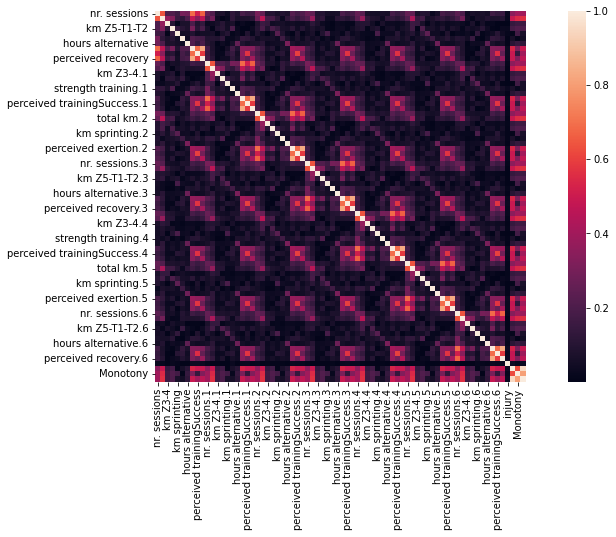

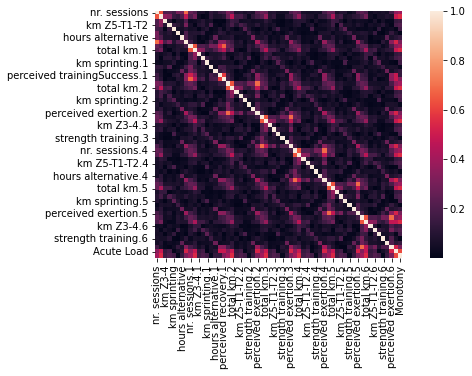

In [ ]:
''' Plot heatmap correlation matrix before and after dropping variables with high correlation '''

!pip install collinearity
from collinearity import SelectNonCollinear

selector = SelectNonCollinear(0.6)
selector.fit(X,y)
mask = selector.get_support()
df_non_collinear = pd.DataFrame(X[:,mask],columns=np.array(column_names)[mask])

plt.figure(figsize=[15,15])
plt.subplot(2,1,1)
sns.heatmap(df.corr(method='spearman').abs(),square=True)
plt.show()

plt.figure(figsize=[10,10])
plt.subplot(2,1,2)
sns.heatmap(df_non_collinear.corr(method='spearman').abs(),square=True)
plt.show()


In [ ]:
'''Partial Least Squares VIP scores'''

# partial least squares vip scores (more suitable for variable selection when multicollinearity is present)
# we defined good predictors when vip score > 1, as it's suggested by the paper from Il-Gyo Chong & Chi-Hyuck Jun 2005
# function calculate_vips was taken from Keiron Teilo O'Shea, found on a researchgate forum

def calculate_vips(model):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

pls = PLSRegression()
pls.fit_transform(X_scaled,y)
vip = calculate_vips(pls)
df_pls_vip = pd.DataFrame()
df_pls_vip["Feature"] = column_names
df_pls_vip["VIP SCORE"] = vip
df_pls_vip["Beta SCORE"] = np.abs(pls.coef_)
df_sorted = df_pls_vip.sort_values(by = ["VIP SCORE"],ascending = False)
print(df_sorted[:20])

                        Feature  VIP SCORE  Beta SCORE
11                   total km.1   1.926352    0.001310
15          strength training.1   1.770726    0.001354
7            perceived exertion   1.594940    0.000967
72                       Strain   1.568984    0.000565
70                   Acute Load   1.488541    0.000133
47         perceived exertion.4   1.480695    0.000845
57         perceived exertion.5   1.473436    0.000846
27         perceived exertion.2   1.450020    0.000792
67         perceived exertion.6   1.359205    0.000725
48  perceived trainingSuccess.4   1.356474    0.000598
8     perceived trainingSuccess   1.355141    0.000589
37         perceived exertion.3   1.315276    0.000660
38  perceived trainingSuccess.3   1.267242    0.000464
28  perceived trainingSuccess.2   1.257037    0.000283
64               km sprinting.6   1.257011    0.000951
71                     Monotony   1.242844    0.000638
58  perceived trainingSuccess.5   1.240521    0.000035
18  percei

In [ ]:
'''Construct 3 principal components with principal component analysis'''

pca = PCA(n_components=3)
pca.fit(X_scaled)
pca_features = pca.transform(X_scaled)
pca_df = pd.DataFrame(pca_features,columns=['PCA1','PCA2','PCA3'])
target_var = []
for i in y:
  if i == 0:
    target_var.append('Healthy')
  else:
    target_var.append('Injured')
df_target_var = pd.DataFrame(target_var,columns=['Group'])
df_pca = pd.concat([pca_df,df_target_var],axis=1)
loading_scores = pca.components_
df_loadings = pd.DataFrame(loading_scores.T,columns=['PCA1','PCA2','PCA3'],index=column_names)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(np.round(explained_variance,decimals=2))
df_explained_var = pd.concat([pd.DataFrame(['PCA1','PCA2','PCA3'],columns=['PC']),
                              pd.DataFrame(explained_variance,columns=['Explained Variance']),
                              pd.DataFrame(cumulative_variance,columns=['Cumulative Variance'])],axis=1)
print(df_pca)

           PCA1      PCA2      PCA3    Group
0     -1.049549  0.184176  0.323932  Healthy
1     -1.050321  0.186830 -0.242768  Healthy
2     -1.049864  0.194955  0.043869  Healthy
3     -1.049584  0.195964  0.095208  Healthy
4     -0.944940  0.388996 -0.207783  Healthy
...         ...       ...       ...      ...
42761  0.632232 -0.362061 -0.210319  Healthy
42762  0.985391 -0.335924 -0.031760  Healthy
42763  1.076517 -0.342464  0.078566  Healthy
42764  0.691943 -0.346038 -0.239258  Healthy
42765  0.771248 -0.311953  0.488505  Healthy

[42766 rows x 4 columns]


In [ ]:
# Scree Plot

fig = go.Figure()

fig.add_trace(go.Bar(x=df_explained_var['PC'],y=df_explained_var['Explained Variance'],marker=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=df_explained_var['PC'],y=df_explained_var['Cumulative Variance'],marker=dict(size=12,color='DarkViolet')))
fig.show()

In [ ]:
# PCA components 3d plot

fig = px.scatter_3d(df_pca,x='PCA1',y='PCA2',z='PCA3',color=df_pca['Group'],opacity=0.5)
fig.update_layout(template='plotly_dark')
fig.show()

In [ ]:
# Loading scores plot

loading_scores_labels = df_loadings.index
fig = px.scatter_3d(df_loadings,x='PCA1',y='PCA2',z='PCA3',text=loading_scores_labels)
fig.show()

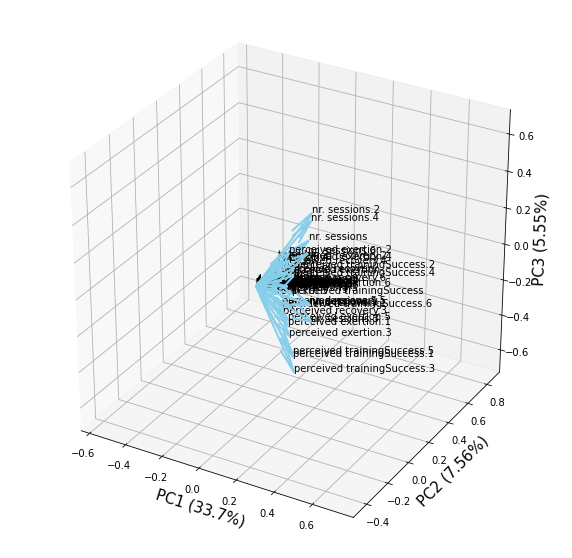

In [ ]:
'''PCA Biplot'''

cluster.biplot(cscore=pca_features,loadings=loading_scores,labels=loading_scores_labels,
                var1=np.round(df_explained_var['Explained Variance'][0]*100,2),
               var2=np.round(df_explained_var['Explained Variance'][1]*100,2),
               var3=np.round(df_explained_var['Explained Variance'][2]*100,2),
               show=True,colorlist=target_var,dim=(10,10),dotsize=12,arrowlinewidth=2,axlabelfontsize=15,
               valphaarrow=1,valphadot=0.1,datapoints=False)

### **We observe that the 3 principal components we constructed, explain a small percentage of total dataset's variation. Therefore we have lost a lot of information by plotting the 3 principal components, so we cannot extract valid insights. We will perform multidimensional scaling (MDS) to visualize if any clusters are present between the two classes in target variable. Because MDS is computationally expensive we will undersample the majority class (healthy) to have equal number of instances with the minority class (injury).**

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy=1,random_state=21)
X_resamp,y_resamp = undersampler.fit_resample(X,y)
X_resamp_scaled = MinMaxScaler().fit_transform(X_resamp)
df_resamp = pd.DataFrame(X_resamp,columns=column_names)
df_resamp['injury'] = y_resamp
print(df_resamp['injury'].value_counts())

1    583
0    583
Name: injury, dtype: int64


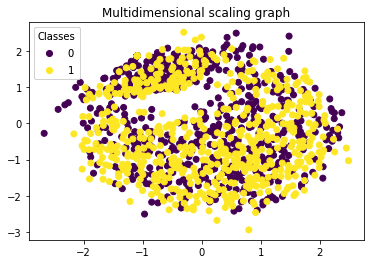

In [ ]:
'''Multidimensional scaling graph'''

mds = MDS(n_components=2,random_state=21,metric=True)
mds_coordinates = mds.fit_transform(X_resamp_scaled)

mds_df = pd.DataFrame(mds_coordinates,columns=["x","y"],index=df_resamp.index)
mds_df = pd.concat([mds_df,pd.Series(df_resamp['injury'])],axis=1)

fig, ax = plt.subplots()

scatter = ax.scatter(mds_df.x, mds_df.y,c=mds_df['injury'])
plt.title('Multidimensional scaling graph')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
#for sample in mds_df.index:
 #   plt.annotate(sample,(mds_df.x.loc[sample],mds_df.y.loc[sample]))
plt.show()

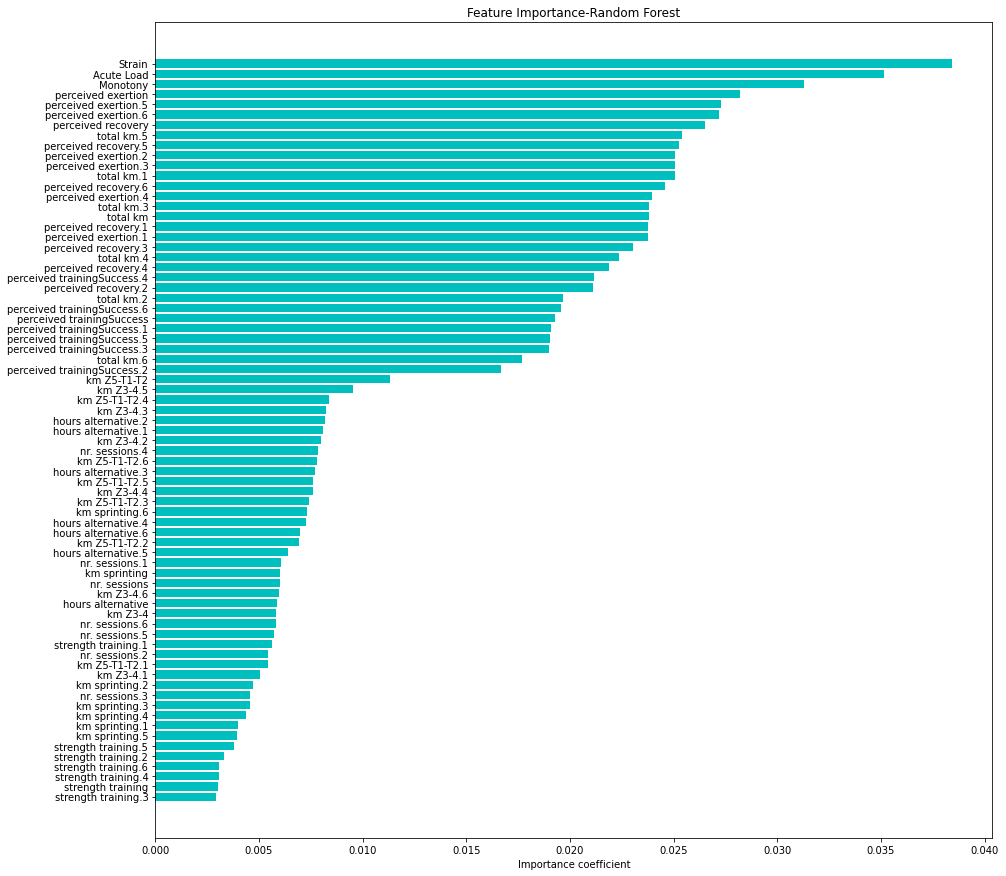

In [ ]:
'''Random Forest Classifier for Features Importance'''

# use random forest to find feature importance coefficients
rand_for = RandomForestClassifier()
rand_for.fit(X_resamp,y_resamp)
feature_importance = rand_for.feature_importances_
indices = np.argsort(feature_importance)

# plot random forest feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(indices)),feature_importance[indices],color ="c",align="center")
plt.yticks(range(len(indices)),[column_names[i] for i in indices])
plt.title("Feature Importance-Random Forest")
plt.xlabel("Importance coefficient")
plt.show()

In [ ]:
'''Optimize Random Forest Classifier to take proximity matrix'''

# create random forest model, fit data and crossvalidate to find best cost complexity parameter

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=21)
rf = RandomForestClassifier()
rscv = RandomizedSearchCV(rf,{'ccp_alpha':[0.001,0.01,0.05,0.1,0.5]},cv=cv,n_iter=5,scoring='roc_auc')
rscv.fit(X_resamp,y_resamp)
print("Best param is {}".format(rscv.best_params_))
print("Best score is {}".format(rscv.best_score_))

optimal_ccp_alpha = rscv.best_params_['ccp_alpha']

tuned_rf = RandomForestClassifier(ccp_alpha=optimal_ccp_alpha)

Best param is {'ccp_alpha': 0.001}
Best score is 0.6574557724425099


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:518: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



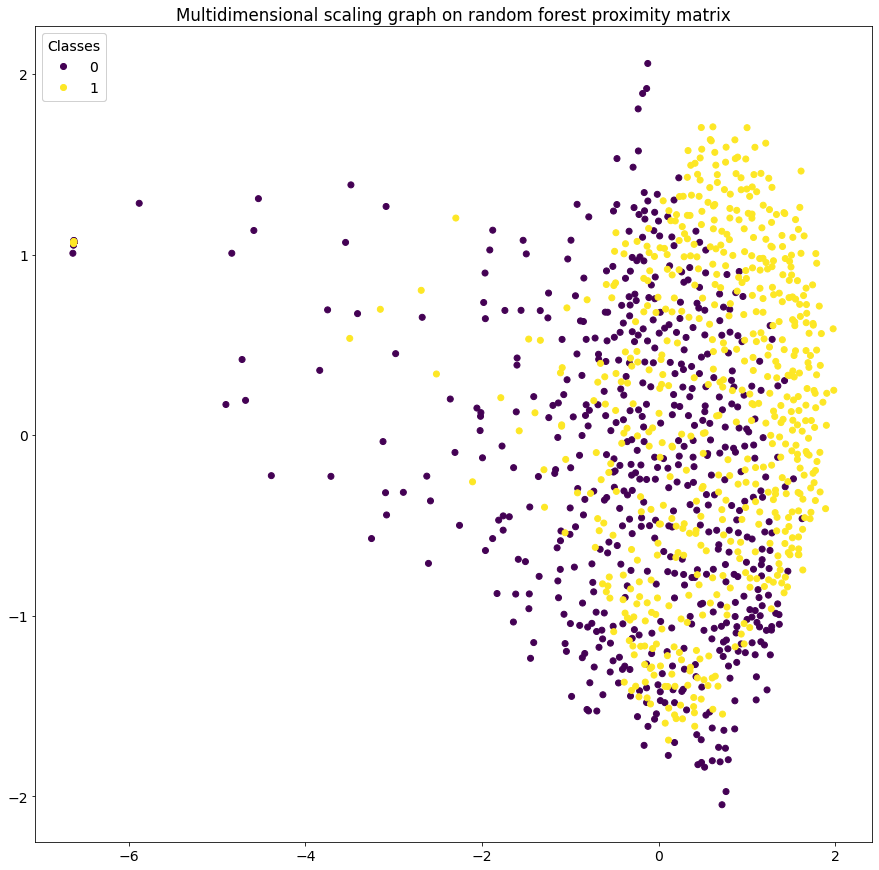

In [ ]:
'''Proximity Matrix Clustering with MDS plot'''

tuned_rf.fit(X_resamp,y_resamp)

#make proximity matrix to cluster subjects
def proximityMatrix(model, X, normalize=True):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

prox_matrix = proximityMatrix(tuned_rf, X_resamp, normalize=True)

#make MDS plot with proximity matrix to find subjects clustering together
mds = MDS(n_components=2,random_state=0,metric=True)
mds_coordinates = mds.fit_transform(prox_matrix)

mds_df = pd.DataFrame(mds_coordinates,columns=["x","y"],index=df_resamp.index)
mds_df = pd.concat([mds_df,pd.Series(df_resamp['injury'])],axis=1)
fig, ax = plt.subplots()

scatter = ax.scatter(mds_df.x, mds_df.y,c=mds_df['injury'])
plt.title('Multidimensional scaling graph on random forest proximity matrix')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
#for sample in mds_df.index:
 #   plt.annotate(sample,(mds_df.x.loc[sample],mds_df.y.loc[sample]))
plt.show()